In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time, datetime

import lkmodels as lkm
import lkhelpers as lkh

### Funciones

In [2]:
# modelos para probar
models = {
# distance models
    'centroide' : lambda s,p: lkm.scores_centroide(s,p,robust=False)
    ,'centroide_robust': lambda s,p: lkm.scores_centroide(s,p,robust=True)
    ,'distancias': lambda s,p: lkm.scores_distancias(s,p,robust=False)
    ,'distancias_robust': lambda s,p: lkm.scores_distancias(s,p,robust=True)
# class models
    ,'logistic': lambda s,p: lkm.scores_clf(s,p,random_state=rng, clf='logistic', penalty='l2')
    ,'tree': lambda s,p: lkm.scores_clf(s,p,random_state=rng, clf='tree', min_samples_leaf=0.01)
    ,'rf': lambda s,p: lkm.scores_clf(s,p,random_state=rng, clf='rf', min_samples_leaf=100,
                                     n_estimators=200, max_features='sqrt')
# bagged models        
    ,'bagged50_logistic': lambda s,p: lkm.scores_bagged_clf(s,p,random_state=rng, clf='logistic' 
                                                           ,T=50,penalty='none')
    ,'bagged50_tree': lambda s,p: lkm.scores_bagged_clf(s,p,random_state=rng, clf='tree' 
                                                           ,T=50, min_samples_leaf=0.01)
    ,'bagged50_tree_flex': lambda s,p: lkm.scores_bagged_clf(s,p,random_state=rng, clf='tree' 
                                                           ,T=50, min_samples_leaf=1)
}

In [3]:
models.items()

dict_items([('centroide', <function <lambda> at 0x1C931A90>), ('centroide_robust', <function <lambda> at 0x1C931898>), ('distancias', <function <lambda> at 0x1C931B20>), ('distancias_robust', <function <lambda> at 0x1C931D60>), ('logistic', <function <lambda> at 0x1C931970>), ('tree', <function <lambda> at 0x1C931A48>), ('rf', <function <lambda> at 0x1C931BB0>), ('bagged50_logistic', <function <lambda> at 0x1C931BF8>), ('bagged50_tree', <function <lambda> at 0x1C931C40>), ('bagged50_tree_flex', <function <lambda> at 0x1C931D18>)])

In [10]:
# resultados de cada modelo en un dataset dado
def lk_report(X, y, idx_hidden, models_dict):
    X_seed = X[y == 1,:]
    X_poblacion = X[y == 0,:]
    metrics = dict()
    times = dict()
    for k,f in models.items():
        t0 = time.time()
        scores = f(X_seed, X_poblacion)
        metrics[k] = lkh.avg_precision(y, idx_hidden, scores) * 100
        times[k] = (time.time() - t0) / 60
    df = pd.DataFrame({'precision': metrics, 'time': times})
    return df

### Simulación

In [14]:
rng = np.random.RandomState(999)
datasets = dict()

datasets['baseline'] = lkh.make_dataset(rng, n_samples=10000, n_features=20, weights=[0.90, 0.10]
                                       ,n_informative=15, n_redundant=5, n_repeated=0)
datasets['low_dim'] = lkh.make_dataset(rng, n_samples=10000, n_features=5, weights=[0.90, 0.10]
                                       ,n_informative=5, n_redundant=0, n_repeated=0)
datasets['high_dim'] = lkh.make_dataset(rng, n_samples=10000, n_features=200, weights=[0.90, 0.10]
                                       ,n_informative=15, n_redundant=0, n_repeated=0)
datasets['contaminated'] = lkh.make_dataset(rng, n_samples=10000, n_features=20, weights=[0.90, 0.10]
                                       ,n_informative=15, n_redundant=5, n_repeated=0, flip_y=0.2)
datasets['no_sep'] = lkh.make_dataset(rng, n_samples=10000, n_features=20, weights=[0.90, 0.10]
                                       ,n_informative=15, n_redundant=5, n_repeated=0, class_sep=0.5)
datasets['clusters'] = lkh.make_dataset(rng, n_samples=10000, n_features=20, weights=[0.90, 0.10]
                                       ,n_informative=15, n_redundant=5, n_repeated=0, n_clusters_per_class=4)

In [15]:
rdos = dict()
for k,v in datasets.items():
    rdos[k] = lk_report(v[0], v[1], v[2], models)
    print(f'{datetime.datetime.now()}: {k} DONE ---')

2020-09-30 21:16:18.607163: baseline DONE ---
2020-09-30 21:16:29.533863: low_dim DONE ---
2020-09-30 21:18:26.141846: high_dim DONE ---
2020-09-30 21:18:52.642682: contaminated DONE ---
2020-09-30 21:19:14.497932: no_sep DONE ---
2020-09-30 21:19:34.646693: clusters DONE ---


In [12]:
rdos.items()

dict_items([('baseline',                     precision      time
centroide           17.511365  0.000088
centroide_robust    15.576279  0.000128
distancias          13.148293  0.000105
distancias_robust   12.903224  0.000167
logistic             5.157057  0.000939
tree                 5.867907  0.000574
rf                   4.955623  0.019218
bagged50_logistic   56.625517  0.018805
bagged50_tree       54.997450  0.003557
bagged50_tree_flex  48.468046  0.003592), ('low_dim',                     precision      time
centroide           12.038752  0.000000
centroide_robust    10.233009  0.000136
distancias          11.505963  0.000000
distancias_robust   11.712836  0.000213
logistic             4.760274  0.000206
tree                 5.511950  0.000169
rf                   4.777883  0.017489
bagged50_logistic   67.312670  0.007841
bagged50_tree       66.184543  0.002004
bagged50_tree_flex  61.295730  0.001941), ('high_dim',                     precision      time
centroide           10.626

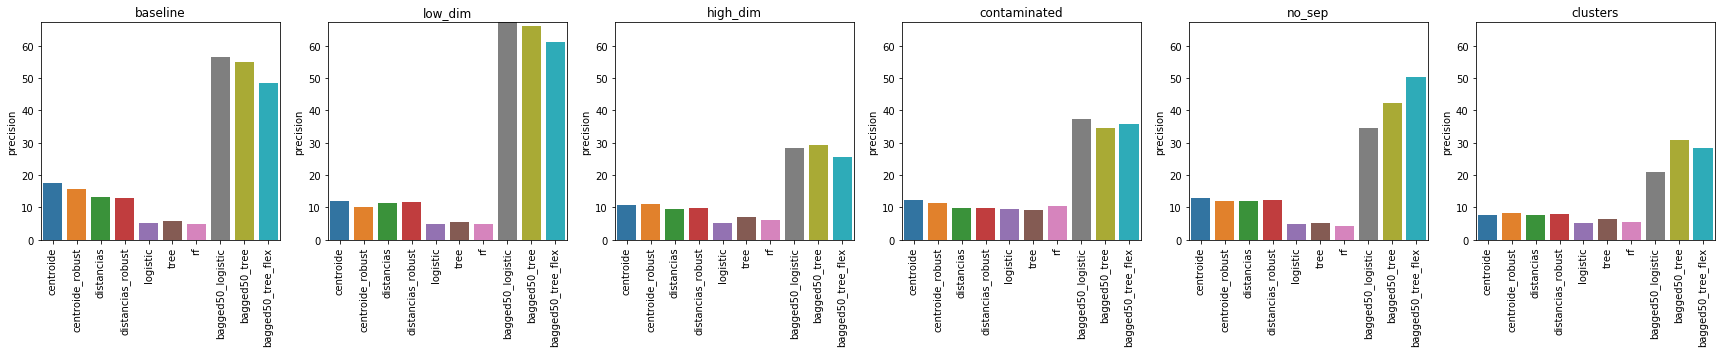

In [13]:
# plot metrics
f, axs = plt.subplots(figsize=(30,4), nrows=1, ncols=len(rdos.keys()))
max_precision = pd.concat(rdos)['precision'].max()
i = 0
for name, df in rdos.items():
    sns.barplot(x=df.index, y=df['precision'], ax=axs[i])
    axs[i].set_title(name)
    axs[i].set_ylim(0, max_precision)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    i += 1